The previous tutorials all work with computed datasets; this tutorial shows how to import and use actual data. Generally, the M+1, M+2, etc. experiments may be coming from different sources. Preparing that data for our solver involves importing it into the "processStandard" and "processSample" format. We often input molecular average measurements manually. We demonstrate here using some Methionine M+1 data; actual datasets from different instruments may need their own system to be processed properly. 

In [1]:
import sys; sys.path.insert(0, '..')

In [2]:
import methionineTest as metTest
import readInput as ri
import fragmentAndSimulate as fas
import solveSystem as ss

import copy
from tqdm import tqdm
import solveSystem as ss
import numpy as np
import sympy as sy

In [3]:
import json

with open('20210505_M1_Results.json') as f:
    sampleOutputDict = json.load(f)

We store out experimental data in .json files; the keys are file names, and their values contain data for that experiment. The dataset has average and standard error values for each peak of each fragment.

In [4]:
sampleOutputDict

{'MetM1/20210505_12_Std01_MetA_M1_2e5.xlsx': {'103.1': {'13C': {'Average': 0.6536009651032442,
    'StdDev': 0.016162774550481318,
    'StdError': 0.00024080667298843127,
    'RelStdError': 0.00036843071819882175,
    'TICVar': 0,
    'TIC*ITVar': 0,
    'TIC*ITMean': 0,
    'ShotNoise': 0.0005935925993512319},
   '15N': {'Average': 0.04714104145002262,
    'StdDev': 0.007154184991031171,
    'StdError': 0.00010658909336718324,
    'RelStdError': 0.0022610678527368875,
    'TICVar': 0,
    'TIC*ITVar': 0,
    'TIC*ITMean': 0,
    'ShotNoise': 0.0017588746248987422},
   'D': {'Average': 0.014160714627649038,
    'StdDev': 0.004254394571964524,
    'StdError': 6.338556534678073e-05,
    'RelStdError': 0.004476155830654149,
    'TICVar': 0,
    'TIC*ITVar': 0,
    'TIC*ITMean': 0,
    'ShotNoise': 0.0031581219774021},
   'Unsub': {'Average': 0.28509727881908437,
    'StdDev': 0.01526043120269769,
    'StdError': 0.00022736279930236618,
    'RelStdError': 0.0007974920007800038,
    'TICVar

We wish to standardize while we process this data, so we define our approximate standard now. 

In [5]:
#Approximation for standard
deltas = [-54,-24,-24,-24,0,2.15,0,0,0,0,0,0,0]
fragSubset = ['133','104','102','61','56']
df, expandedFrags, fragSubgeometryKeys, fragmentationDictionary = metTest.initializeMethionine(deltas, fragSubset)

predictedMeasurement, MNDictStd, FF = metTest.simulateMeasurement(df, fragmentationDictionary, expandedFrags, fragSubgeometryKeys, 
                                                   abundanceThreshold = 0,
                                                   massThreshold = 1,
                                                     unresolvedDict = {},
                                                    outputFull = False)

Delta 34S
4.174757281553143
Delta 36S
7.932038834951527
Delta 18O
0.0
Calculating Isotopologue Concentrations


  1%|▍                                                                        | 3576/663552 [00:00<00:18, 35666.33it/s]

Compiling Isotopologue Dictionary


100%|███████████████████████████████████████████████████████████████████████| 663552/663552 [00:31<00:00, 21256.64it/s]


Simulating Measurement


Our experiment processing software assigns each fragment a key based on observed mass; we wish to connect these to our "fragSubgeometryKeys", which we do with the "processFragKeys" dictionary. We can also specify whether each input file is a sample or standard with the standard list. 

This function prints the values of the observed fragment keys, which can help us define processFragKeys for new data. 

In [6]:
processFragKeys = {'134.0':'133',
                   '105.1':'104',
                   '103.1':'102',
                   '62.0':'61',
                   '57.1':'56'}
    
replicateData = ri.readObservedData(sampleOutputDict, theory = predictedMeasurement,
                                   standard = [True, False, True, False, True, False, True],
                                   processFragKeys = processFragKeys)

103.1
105.1
134.0
57.1
62.0
75.0
75.1
88.0
103.1
105.1
134.0
57.1
62.0
75.0
75.1
88.0
103.1
105.1
134.0
57.1
62.0
75.0
75.1
88.0
103.1
105.1
134.0
57.1
62.0
75.0
75.1
88.0
103.1
105.1
134.0
57.1
62.0
75.0
75.1
88.0
103.1
105.1
134.0
57.1
62.0
75.0
75.1
88.0
103.1
105.1
134.0
57.1
62.0
75.0
75.1
88.0


In [7]:
replicateDataKeys = list(replicateData.keys())

Our import .json did not include any full molecule U Value data; we usually set that manually. For example, we find the value here:

In [8]:
import basicDeltaOperations as op

U13C = op.concentrationToM1Ratio(op.deltaToConcentration('13C',-31.9)) * 5

UValuesSmp = {'13C':{'Observed': U13C, 'Error': U13C * 0.000}}

In [9]:
sixtyOneCorrect = {'MNKey':'M1','fragToCorrect':'61','subToCorrect':'33S','fragsToBenchmarkFrom':['104']}
experimentalPACorrection = [sixtyOneCorrect]

We'll process both sample standard comparisons and save the results to a dictionary

In [10]:
sixtyOneCorrect = {'MNKey':'M1','fragToCorrect':'61','subToCorrect':'33S','fragsToBenchmarkFrom':['104']}
experimentalUValueCorrection = [sixtyOneCorrect]

fullResults = {}
for i in range(1,7,2):
    firstBracket = replicateData[replicateDataKeys[i-1]]
    secondBracket = replicateData[replicateDataKeys[i+1]]

    processStandard = {'M1':{}}
    for fragKey, fragInfo in firstBracket['M1'].items():
        avgAbund = (np.array(fragInfo['Observed Abundance']) + np.array(secondBracket['M1'][fragKey]['Observed Abundance'])) / 2
        combinedErr = np.sqrt(np.array(fragInfo['Error']) **2 + np.array(secondBracket['M1'][fragKey]['Error'])**2)
        processStandard['M1'][fragKey] = {'Subs':fragInfo['Subs'],
                                          'Predicted Abundance':fragInfo['Predicted Abundance'],
                                          'Observed Abundance':avgAbund,
                                          'Error':combinedErr}

    processSample = replicateData[replicateDataKeys[i]]

    isotopologuesDict = fas.isotopologueDataFrame(MNDictStd, df)
    pACorrection = ss.percentAbundanceCorrectTheoretical(predictedMeasurement, 
                                                   processSample,
                                                   massThreshold = 1)

    M1Results = ss.M1MonteCarlo(processStandard, processSample, pACorrection, isotopologuesDict,
                                fragmentationDictionary, experimentalPACorrectList = experimentalPACorrection, 
                                N = 1000, GJ = False, debugMatrix = False, pACorrect = True, WCorrect = True,
                               perturbTheoryPAAmt = 0.001)

    processedResults = ss.processM1MCResults(M1Results, UValuesSmp, isotopologuesDict, df, GJ = False, 
                                             UMNSub = ['13C'])
    
    fullResults['Replicate ' + str(i // 2)] = processedResults
    
ss.updateSiteSpecificDfM1MC(processedResults, df)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 139.56it/s]


,IDS,Number,deltas,133_01,104_01,102_01,61_01,56_01,PDB etc. Deltas,PDB etc. Deltas Error,Relative Deltas,Relative Deltas Error,M1 Percent Abundance,M1 Percent Abundance Error,UM1,UM1 Error,Calc U Values,Calc U Values Error
Cmethyl,C,1,-54,1,1,x,1,x,-55.242103,2.202767,-1.313005,2.328506,0.154903,0.000402,0.068536,0.000055,0.010616,0.000025
Cgamma,C,1,-24,1,1,1,1,1,-27.346715,3.114402,-3.429011,3.190986,0.159477,0.000441,0.068536,0.000055,0.010930,0.000035
Calphabeta,C,2,-24,1,1,1,x,1,-26.255207,0.974445,-2.310663,0.998406,0.319311,0.000283,0.068536,0.000055,0.021884,0.000022
Ccarboxyl,C,1,-24,1,x,1,x,x,-24.400767,3.070184,-0.410622,3.145680,0.159960,0.000618,0.068536,0.000055,0.010963,0.000035
Ocarboxyl,O,2,0,1,x,1,x,x,-41.435207,69.274124,-41.435207,69.274124,0.010626,0.000761,0.068536,0.000055,0.000728,0.000053
Ssulfur,S,1,2.15,1,1,x,1,x,-1.664002,1.392586,-3.805820,1.389599,0.114741,0.000118,0.068536,0.000055,0.007864,0.000011
Namine,N,1,0,x,1,1,x,1,-6.370526,2.178779,-6.370526,2.178779,0.053294,0.000111,0.068536,0.000055,0.003653,0.000008
Hmethyl,H,3,0,1,1,x,1,x,10.481021,49.952618,10.481021,49.952618,0.006889,0.000339,0.068536,0.000055,0.000472,0.000023
Hgamma,H,2,0,1,1,1,1,1,110.233441,107.331781,110.233441,107.331781,0.005046,0.000489,0.068536,0.000055,0.000346,0.000033
Halphabeta,H,3,0,1,1,1,x,1,-125.720510,107.728551,-125.720510,107.728551,0.005961,0.000734,0.068536,0.000055,0.000409,0.000050


This allows us to make replicate comparisons for this dataset

In [11]:
fullResultsMeansStds = {'Mean':[],'Std':[]}
for replicate, replicateInfo in fullResults.items():
    mean = np.array(replicateInfo['Relative Deltas']).T.mean(axis = 1)
    std = np.array(replicateInfo['Relative Deltas']).T.std(axis = 1)
    
    fullResultsMeansStds['Mean'].append(mean)
    fullResultsMeansStds['Std'].append(std)
    
fullResultsMeansStds['Mean'] = np.array(fullResultsMeansStds['Mean']).T
fullResultsMeansStds['Std'] = np.array(fullResultsMeansStds['Std']).T

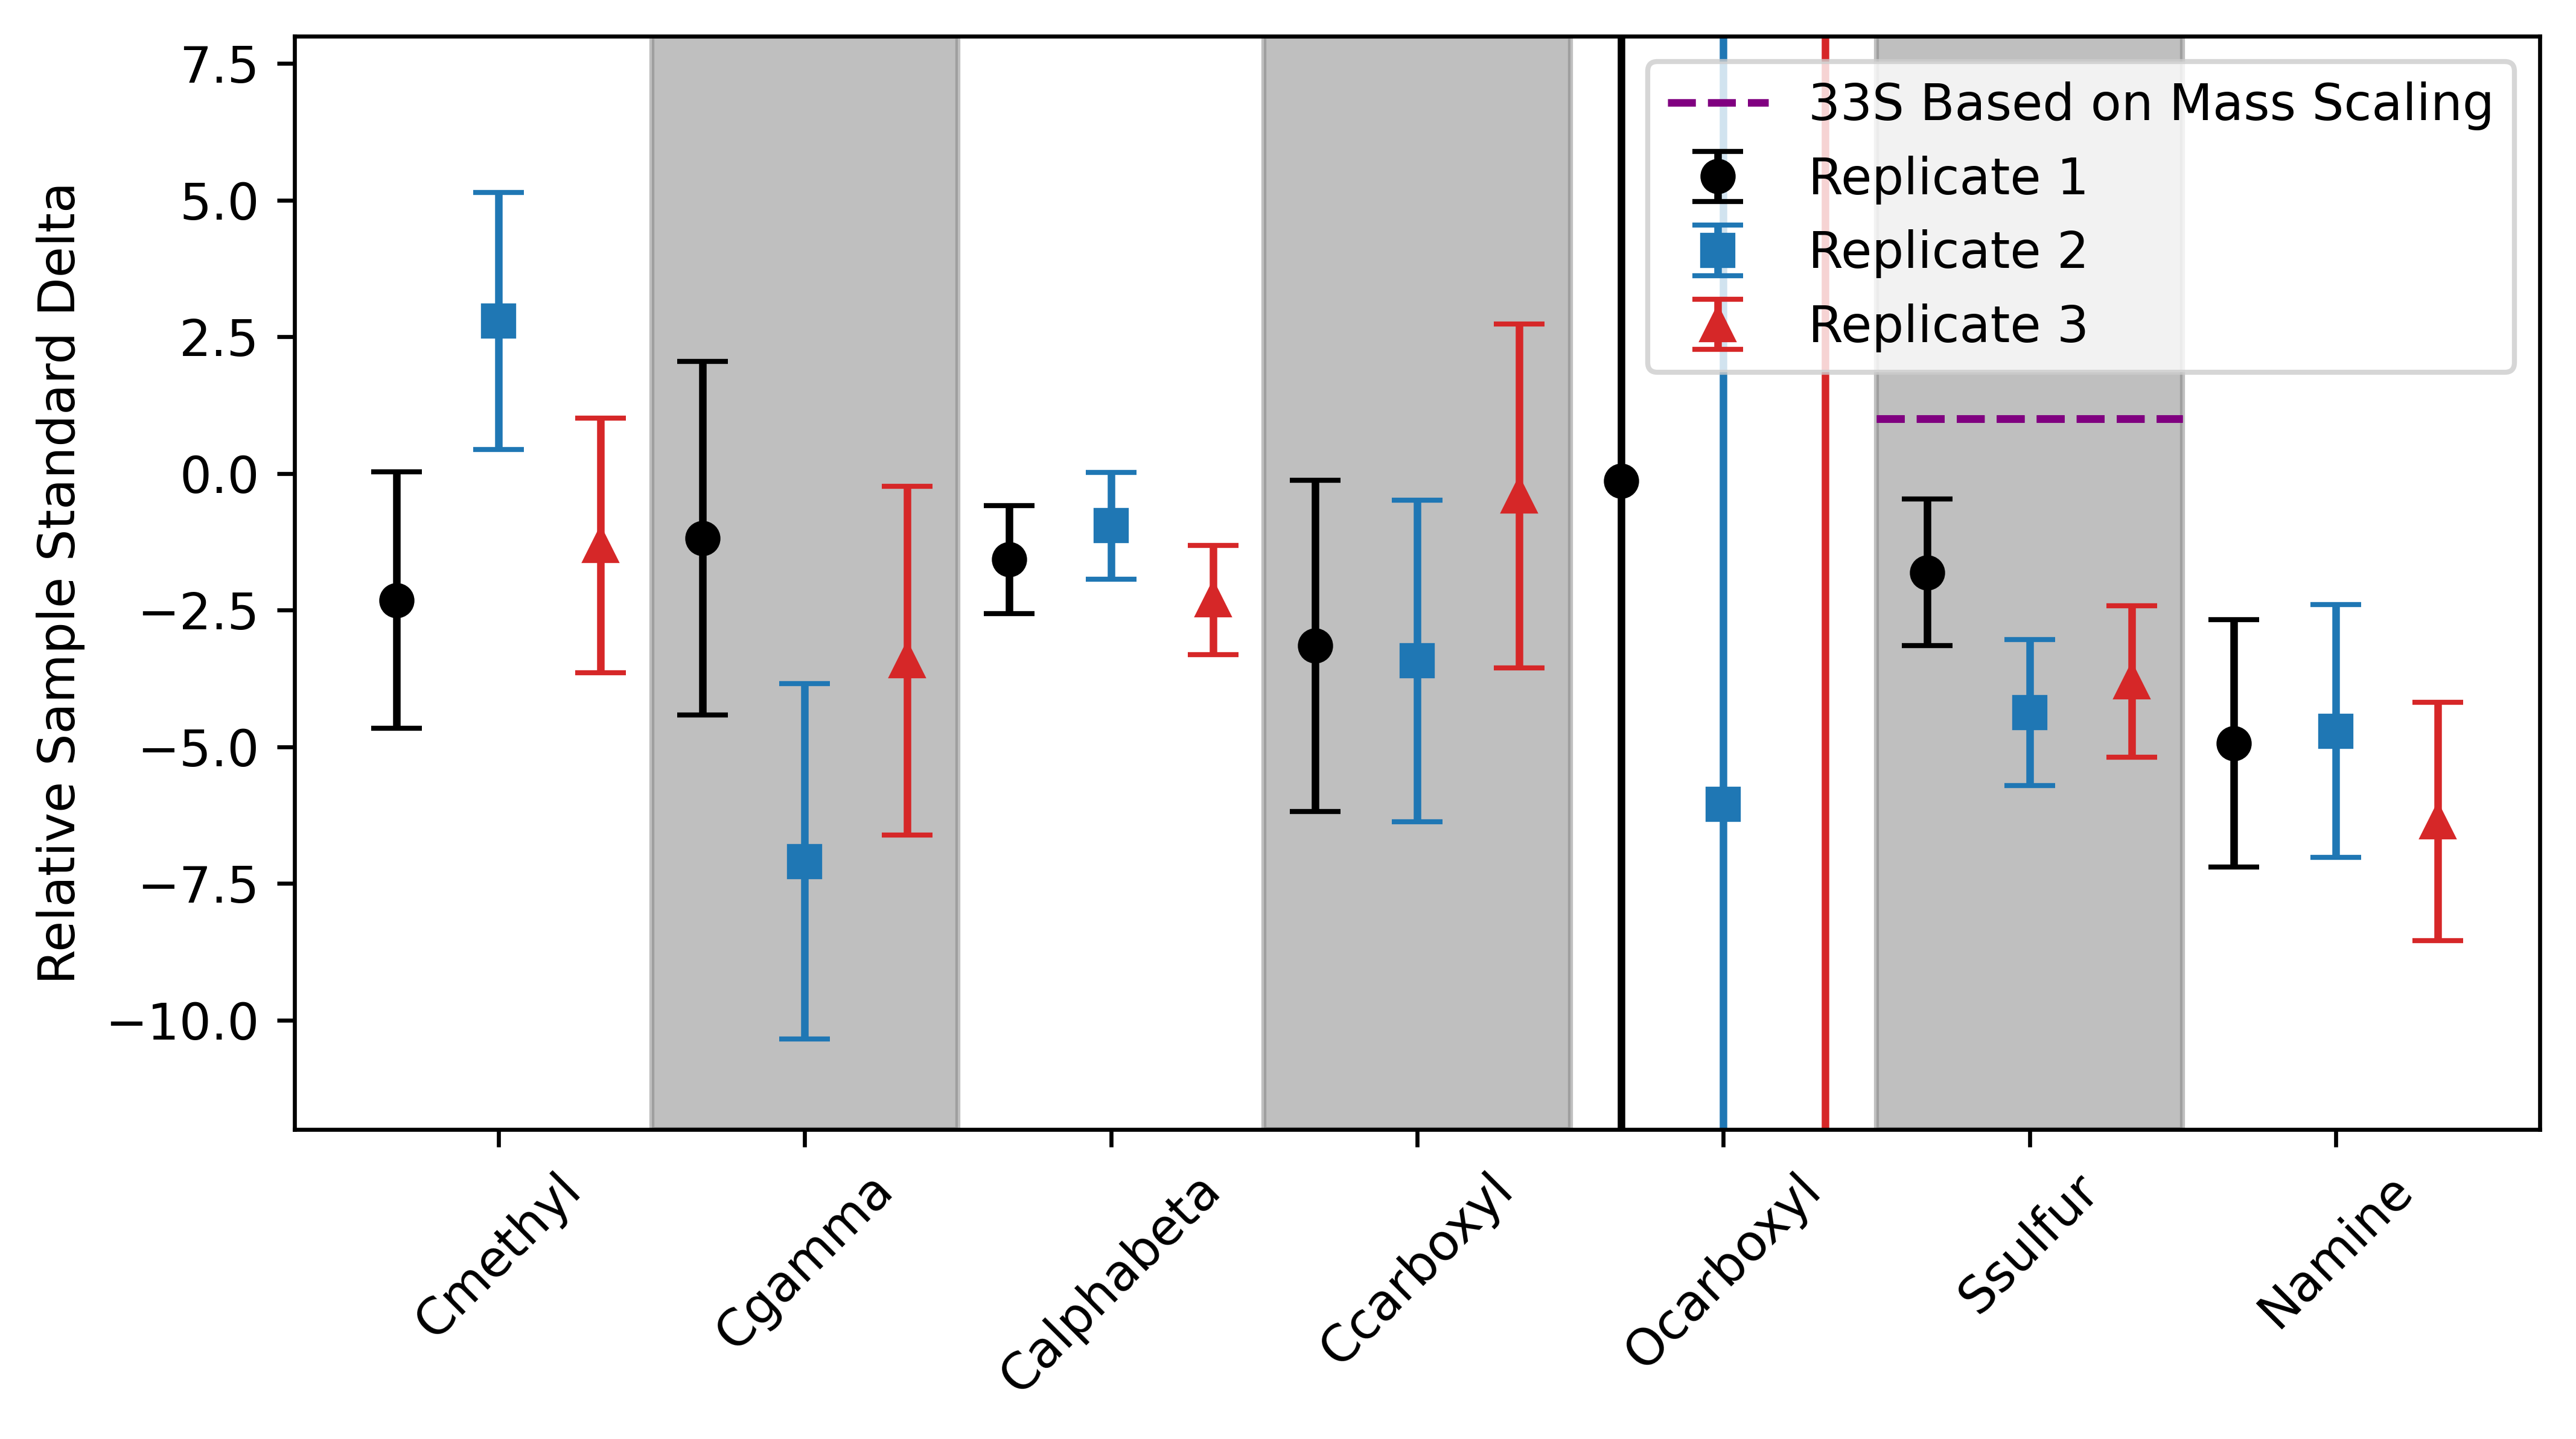

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.rcParams.update({'errorbar.capsize': 5})
fig, ax = plt.subplots(figsize = (8,4), dpi = 600)

observedMeans = []
observedStds = []
nReplicates = 3
for siteIdx, site in enumerate(df.index[:7]):
    observedMeans += list(fullResultsMeansStds['Mean'][siteIdx])
    observedStds += list(fullResultsMeansStds['Std'][siteIdx])
    
means = np.array(observedMeans)
std = np.array(observedStds)
xs = np.array(range(len(means)))
    
colors = ['k','tab:blue','tab:red','tab:brown','tab:purple']
markers = ['o','s','^','h','D']
labels = ['Replicate 1', 'Replicate 2','Replicate 3']
for i in range(nReplicates):
    ax.errorbar(xs[i::nReplicates],means[i::nReplicates],std[i::nReplicates],
             fmt = markers[i], c= colors[i], label = labels[i])
    
nRatios = len(means) // nReplicates
xticks = [x*nReplicates + 1 for x in range(nRatios)]
ax.set_xticks(xticks)
ticklabels = [df.index[i] for i in range(len(xticks))]
ax.set_xticklabels(ticklabels, rotation = 45)
ax.set_ylabel("Relative Sample Standard Delta")

ax.hlines([1.0015,1.0005],14.5,17.5, color = 'purple',linestyle = '--',label = "33S Based on Mass Scaling")
ax.set_ylim(-12,8)

for i, tick in enumerate(xticks):
        if i % 2 == 1:
            ax.axvspan(tick - nReplicates / 2, tick + nReplicates / 2 , alpha=0.5, color='gray')
            
plt.legend(frameon=True,loc = 'upper right')

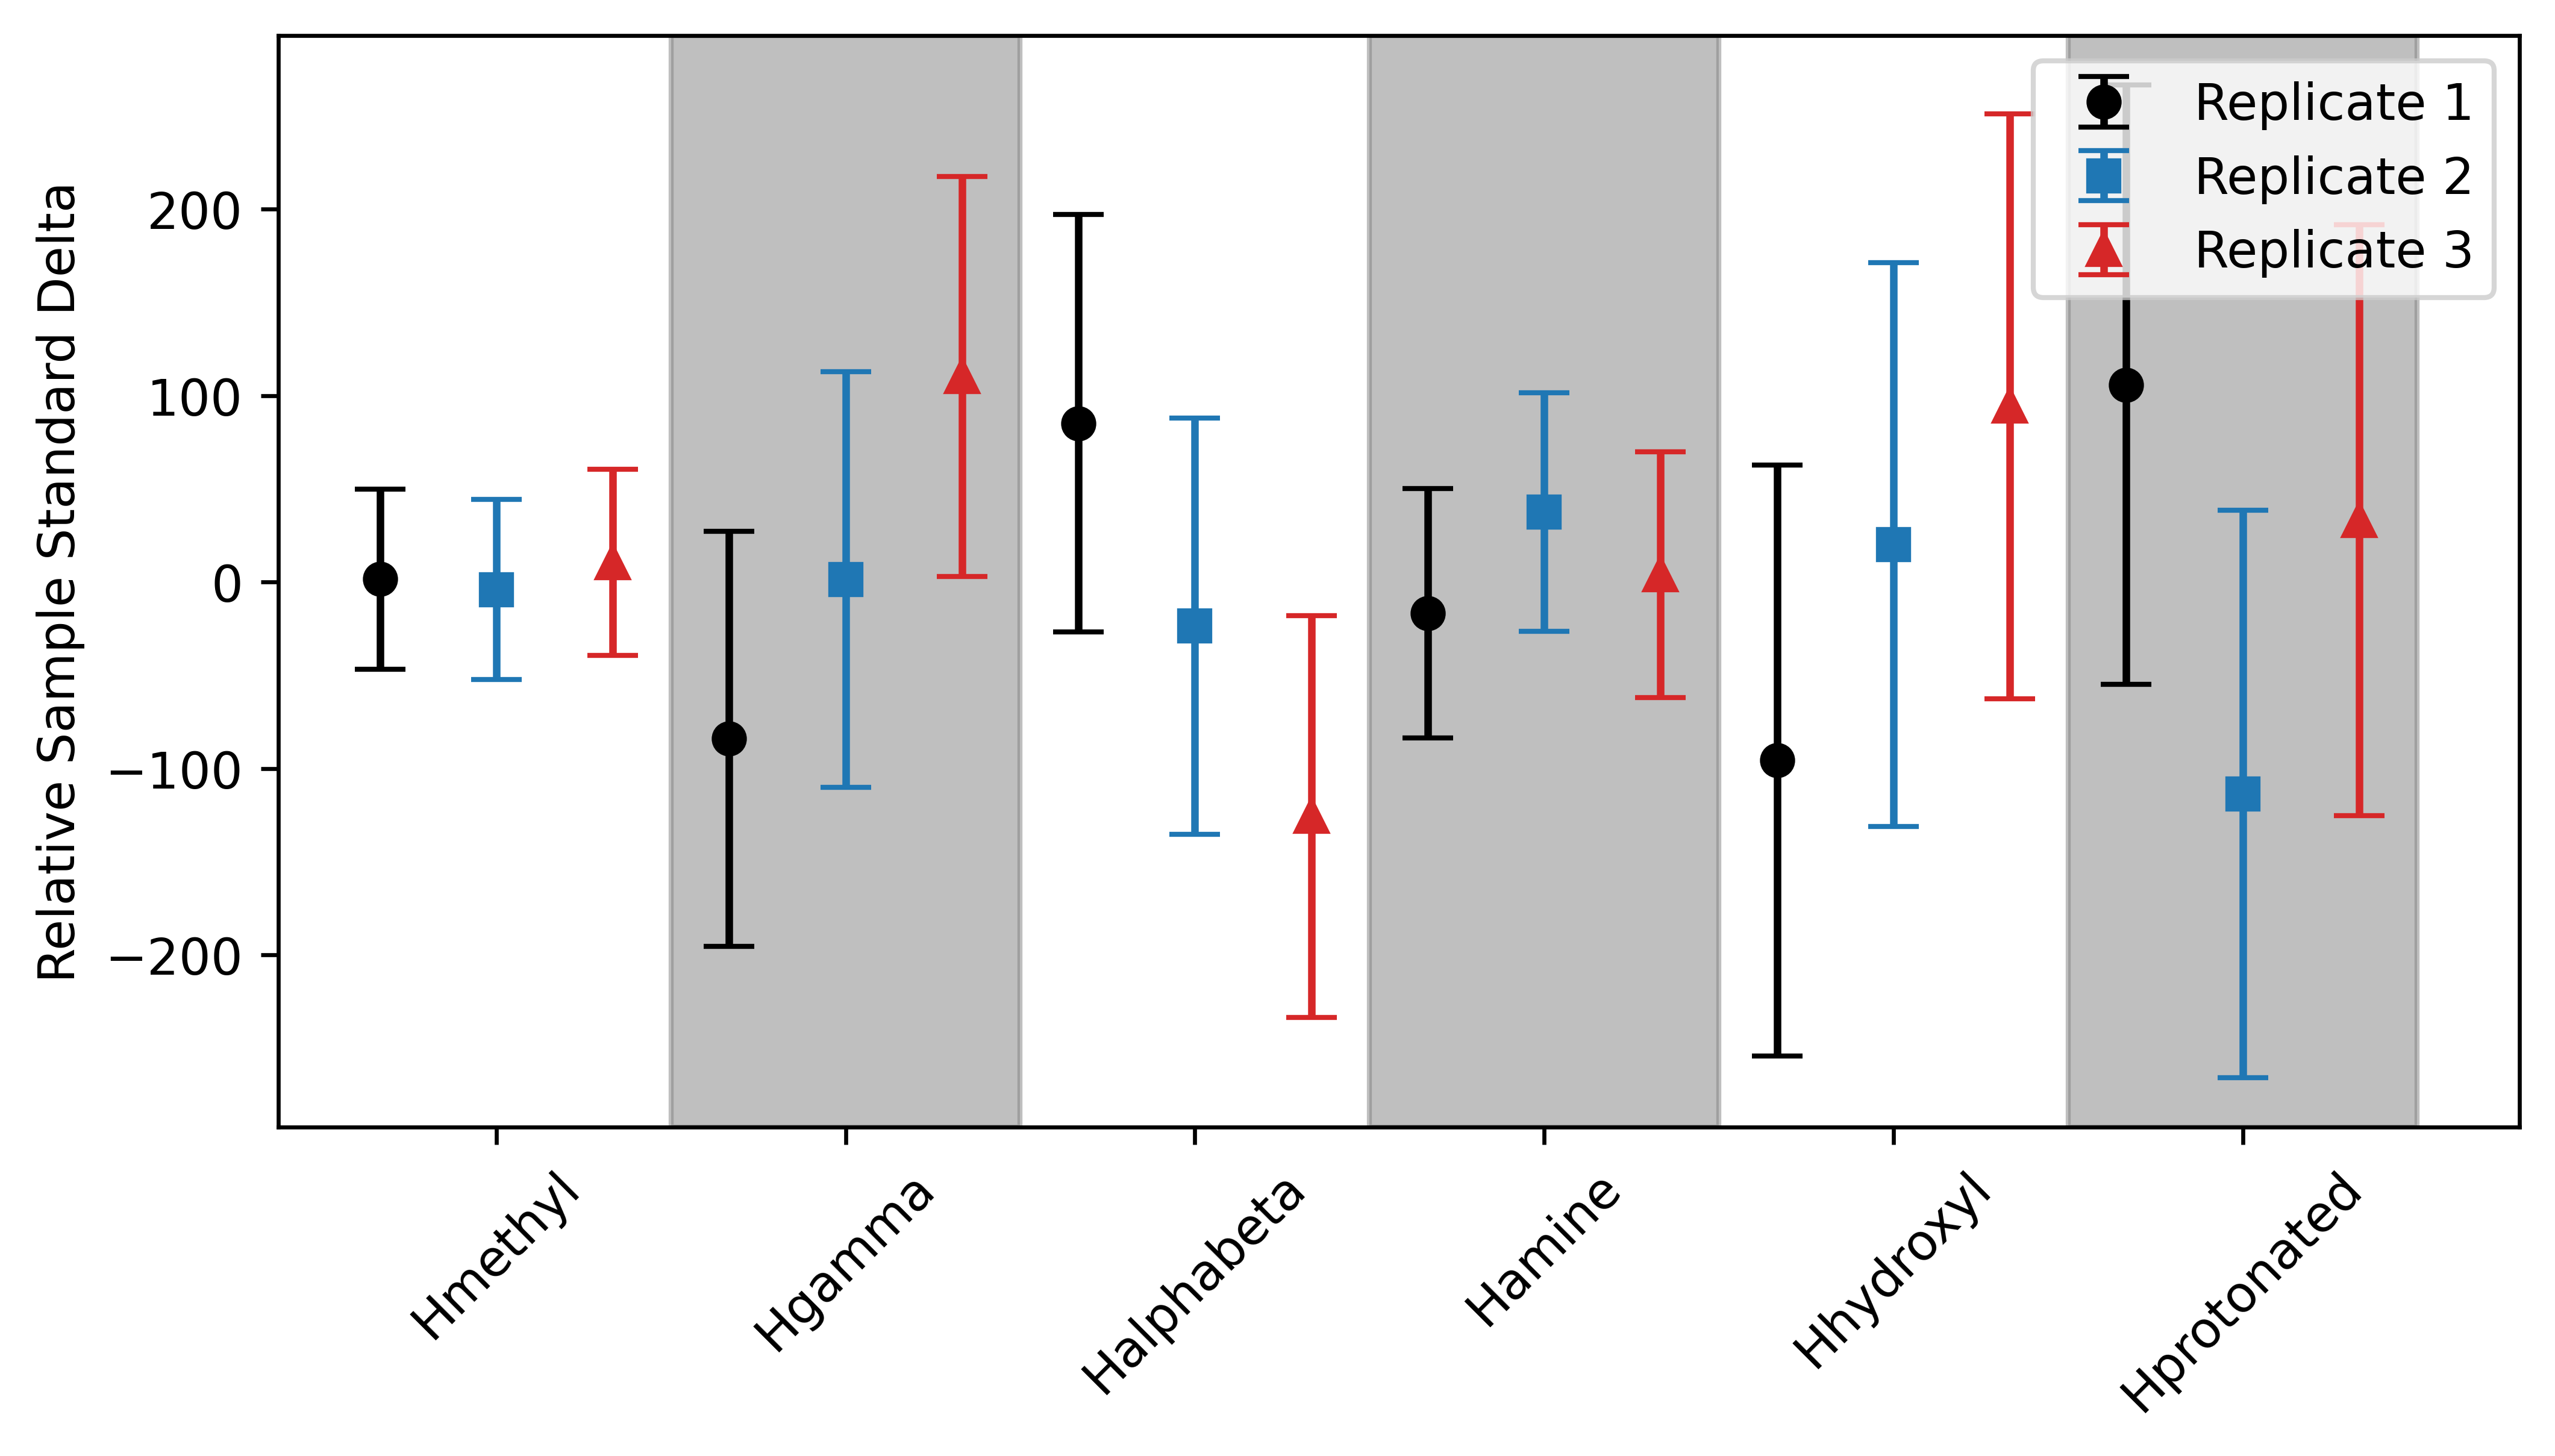

In [13]:
fig, ax = plt.subplots(figsize = (8,4), dpi = 600)

observedMeans = []
observedStds = []
nReplicates = 3
for siteIdx, site in enumerate(df.index[7:]):
    observedMeans += list(fullResultsMeansStds['Mean'][7+siteIdx])
    observedStds += list(fullResultsMeansStds['Std'][7+siteIdx])
    
means = np.array(observedMeans)
std = np.array(observedStds)
xs = np.array(range(len(means)))
    
colors = ['k','tab:blue','tab:red','tab:brown','tab:purple']
markers = ['o','s','^','h','D']
labels = ['Replicate 1', 'Replicate 2','Replicate 3']
for i in range(nReplicates):
    ax.errorbar(xs[i::nReplicates],means[i::nReplicates],std[i::nReplicates],
             fmt = markers[i], c= colors[i], label = labels[i])
    
nRatios = len(means) // nReplicates
xticks = [x*nReplicates + 1 for x in range(nRatios)]
ax.set_xticks(xticks)
ticklabels = [df.index[7+i] for i in range(len(xticks))]
ax.set_xticklabels(ticklabels, rotation = 45)
ax.set_ylabel("Relative Sample Standard Delta")

#ax.set_ylim(-12,8)

for i, tick in enumerate(xticks):
        if i % 2 == 1:
            ax.axvspan(tick - nReplicates / 2, tick + nReplicates / 2 , alpha=0.5, color='gray')
            
plt.legend(frameon=True,loc = 'upper right')